File              ML algorithm       accuracy        Precision       Recall          F1-score        Time           
all_data          Naive Bayes        0.78            0.62            0.64            0.63            2.731          


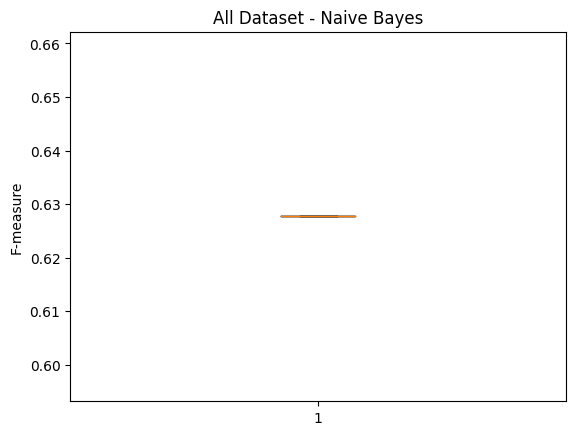

all_data          QDA                0.31            0.58            0.58            0.31            4.4155         


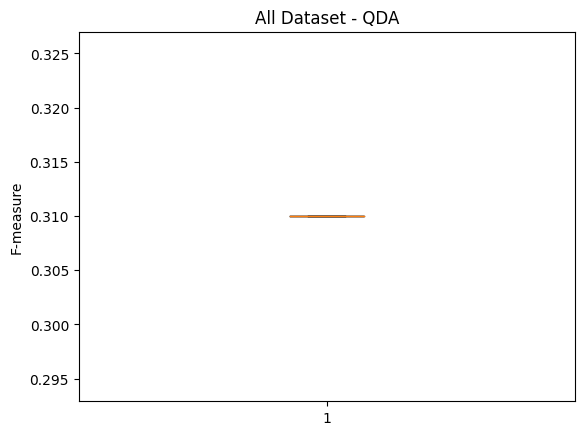

all_data          Random Forest      0.95            0.97            0.84            0.89            9.4277         


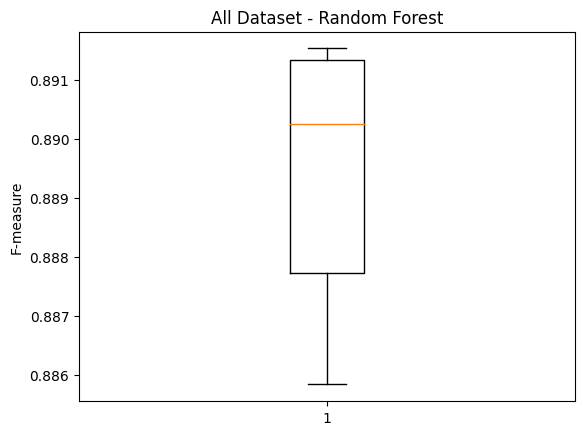

all_data          ID3                0.96            0.94            0.9             0.92            11.363         


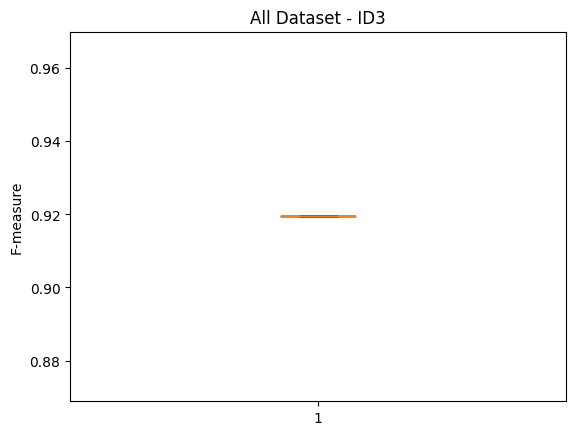

Execution time exceeded 5 minutes. Exiting loop.
all_data          AdaBoost           0.95            0.94            0.88            0.9             155.1325       


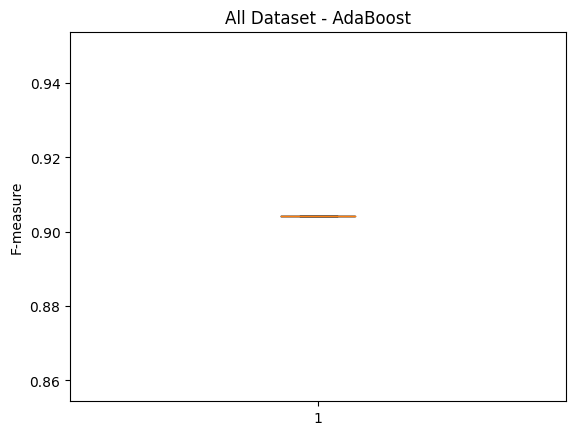

Execution time exceeded 5 minutes. Exiting loop.
all_data          Extra Trees        0.97            0.95            0.96            0.95            217.9878       


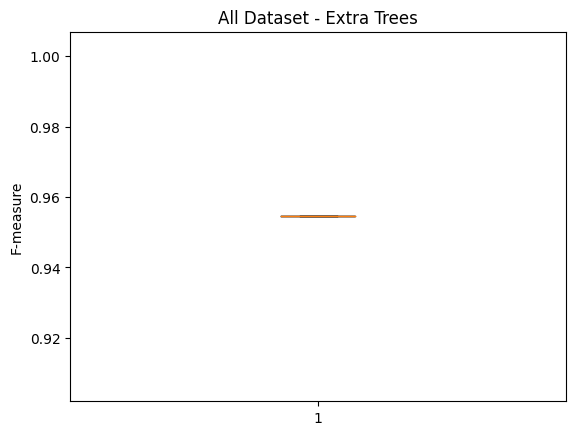

Execution time exceeded 5 minutes. Exiting loop.
all_data          XGBoost            0.97            0.96            0.95            0.95            62.6156        


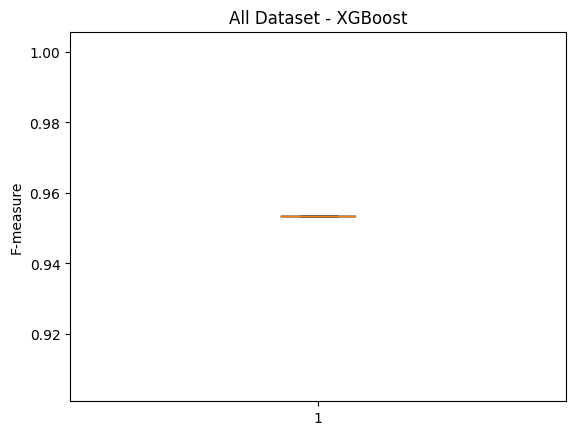

Execution time exceeded 5 minutes. Exiting loop.
all_data          Ensemble           0.97            0.97            0.94            0.95            422.7694       


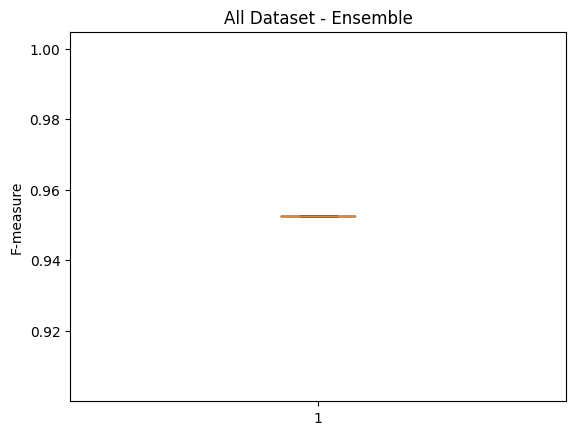

Execution time exceeded 5 minutes. Exiting loop.
mission accomplished!
Total operation time: =  1162.7831165790558 seconds


In [1]:
from sklearn import metrics
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.metrics import average_precision_score, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import csv
import time
import warnings

warnings.filterwarnings("ignore")

result = "./results/results_2.csv"  # a CSV file is named in which the results are saved.
csv_files = ["all_data.csv"]  # CSV files names: #The names of the dataset files (csv_files).
path = ""
repetition = 5

def folder(f_name):  # this function creates a folder named "results" and "result_graph_1" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print("The folder could not be created!")

folder_name = "./results/"
folder(folder_name)
folder_name = "./results/result_graph_2/"
folder(folder_name)

# The machine learning algorithms to be used are defined in a dictionary (ml_list).
ml_list = {
    "Naive Bayes": GaussianNB(),
    "QDA": QDA(),
    "Random Forest": RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    "ID3": DecisionTreeClassifier(max_depth=5, criterion="entropy"),
    "AdaBoost": AdaBoostClassifier(),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=0),
    "XGBoost": XGBClassifier(random_state=0)
}

# Define and add ensemble model
ensemble_model = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)),
    ('ada', AdaBoostClassifier()),
    ('et', ExtraTreesClassifier(n_estimators=100, random_state=0)),
    ('xgb', XGBClassifier(random_state=0))
], voting='soft')
ml_list["Ensemble"] = ensemble_model

# The features to be used for each attack type is defined in a dictionary (features).
# The first 4 of the features created by the file "04_1_feature_selection_for_attack_files.py" are used here.
# The list of these features can be seen in below: ()
features = {"all_data": ["Bwd Packet Length Max", "Bwd Packet Length Mean", "Bwd Packet Length Std", "Flow Bytes/s",
                         "Flow Duration", "Flow IAT Max", "Flow IAT Mean", "Flow IAT Min", "Flow IAT Std", "Fwd IAT Total",
                         "Fwd Packet Length Max", "Fwd Packet Length Mean", "Fwd Packet Length Min", "Fwd Packet Length Std",
                         "Total Backward Packets", "Total Fwd Packets", "Total Length of Bwd Packets", "Total Length of Fwd Packets",
                         "Label"]}

seconds = time.time()  # time stamp for all processing time

with open(result, "w", newline="", encoding="utf-8") as f:  # a CSV file is created to save the results obtained.
    wrt = csv.writer(f)
    wrt.writerow(["File", "ML algorithm", "accuracy", "Precision", "Recall", "F1-score", "Time"])

for j in csv_files:  # this loop runs on the list containing the filenames. Operations are repeated for all attack files
    print('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' % ("File", "ML algorithm", "accuracy", "Precision", "Recall", "F1-score", "Time"))  # print output header
    feature_list = list(features[j[0:-4]])
    df = pd.read_csv(path + j, usecols = feature_list)  # read an attack file.
    df = df.fillna(0)
    attack_or_not = []
    for i in df["Label"]:  # it changes the normal label to "1" and the attack tag to "0" for use in the machine learning algorithm
        if i == "BENIGN":
            attack_or_not.append(1)
        else:
            attack_or_not.append(0)
    df["Label"] = attack_or_not

    y = df["Label"]  # this section separates the label and the data into two separate pieces, as Label=y Data=X
    del df["Label"]
    feature_list.remove('Label')
    X = df[feature_list]

    for ii in ml_list:  # this loop runs on the list containing the machine learning algorithm names. Operations are repeated for all the algorithms
        precision = []
        recall = []
        f1 = []
        accuracy = []
        t_time = []
        for i in range(repetition):  # This loop allows cross-validation and machine learning algorithm to be repeated multiple times
            second = time.time()  # time stamp for processing time

            # Cross-validation
            X_train, X_test, y_train, y_test = train_test_split(X, y,  # data (X) and labels (y) are divided into 2 parts to be sent to the machine learning algorithm (80% train, 20% test).
                                                                test_size=0.20, random_state=repetition)  # So, in total there are 4 tracks: training data(X_train), training tag (y_train), test data(X_test) and test tag(y_test).

            # Machine learning algorithm is applied in this section
            clf = ml_list[ii]  # choose algorithm from ml_list dictionary
            clf.fit(X_train, y_train)
            predict = clf.predict(X_test)

            # Makes "classification report" and assigns the precision, f-measure, and recall values.
            f_1 = f1_score(y_test, predict, average='macro')
            pr = precision_score(y_test, predict, average='macro')
            rc = recall_score(y_test, predict, average='macro')

            precision.append(float(pr))
            recall.append(float(rc))
            f1.append(float(f_1))
            accuracy.append(clf.score(X_test, y_test))
            t_time.append(float((time.time() - second)))

            if time.time() - seconds >= 300:  # Check if 5 minutes (300 seconds) have passed
                print("Execution time exceeded 5 minutes. Exiting loop.")
                break

        print('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' % (j[0:-4], ii, str(round(np.mean(accuracy), 2)), str(round(np.mean(precision), 2)),
                                                               str(round(np.mean(recall), 2)),
str(round(np.mean(f1), 2)), str(round
(np.mean(t_time), 4))))  # the result of the repetitions is printed on the screen.

        with open(result, "a", newline="", encoding="utf-8") as f:  # all the values found are saved in the opened file.
            wrt = csv.writer(f)
            for i in range(0, len(t_time)):
                wrt.writerow([j[0:-4], ii, accuracy[i], precision[i], recall[i], f1[i], t_time[i]])  # file name, algorithm name, precision, recall and f-measure are written in CSV file

        # In this section, Box graphics are created for the results of machine learning algorithms and saved in the feature_graph folder.
        plt.boxplot(f1)
        plt.title("All Dataset - " + str(ii))
        plt.ylabel('F-measure')
        plt.savefig(folder_name + j[0:-4] + str(ii) + ".pdf", bbox_inches='tight', papertype='a4', orientation='portrait', format='pdf')
        plt.show()  # you can remove the # sign if you want to see the graphics simultaneously

    if time.time() - seconds >= 300:  # Check if 5 minutes (300 seconds) have passed
        print("Execution time exceeded 5 minutes. Exiting loop.")
        break

print("mission accomplished!")
print("Total operation time: = ", time.time() - seconds, "seconds")
